In [ ]:
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install pyspark -q

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
# rm -rf /content/train_withds/

In [ ]:
!gsutil -m cp -r gs://spark-result/train_withds /content/

Copying gs://spark-result/train_withds/part-00003-00b31711-9d60-49cb-bcae-847c05006aa7-c000.snappy.parquet...
Copying gs://spark-result/train_withds/part-00004-00b31711-9d60-49cb-bcae-847c05006aa7-c000.snappy.parquet...
Copying gs://spark-result/train_withds/part-00001-00b31711-9d60-49cb-bcae-847c05006aa7-c000.snappy.parquet...
Copying gs://spark-result/train_withds/part-00000-00b31711-9d60-49cb-bcae-847c05006aa7-c000.snappy.parquet...
Copying gs://spark-result/train_withds/part-00002-00b31711-9d60-49cb-bcae-847c05006aa7-c000.snappy.parquet...
Copying gs://spark-result/train_withds/_SUCCESS...


## Load train data

for illustration simplicity, we only pick the first 1000 rows.

In [ ]:
from pyspark.sql import SparkSession, functions as F, Window
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.sql.types import DoubleType
spark = SparkSession.builder.appName("WeatherForecast").getOrCreate()
train_df = spark.read.parquet("/content/train_withds").drop("STATION")
train_df = train_df.withColumn("ELEVATION", train_df["ELEVATION"].cast(DoubleType()))
train_df = train_df.limit(1000)

train_df.show(3)

+-------------------+------+---------+----+----+-------+-----+------+---------+--------+--------------------+--------------------+------------------+------------------+--------------------+---------+-------------------+-------------------+--------------------+-------------------+----------+----------+-----------------+------------------+-------------------+------------------+
|            DATE_TS|dt_min|ELEVATION| TMP| DEW|    VIS|  CIG|   SLP|WND_Speed|TMP_lag1|          time_speed|              time_a|           WND_sin|           WND_cos|           month_sin|month_cos|            day_sin|            day_cos|            hour_sin|           hour_cos|minute_sin|minute_cos|          lat_sin|           lat_cos|            lon_sin|           lon_cos|
+-------------------+------+---------+----+----+-------+-----+------+---------+--------+--------------------+--------------------+------------------+------------------+--------------------+---------+-------------------+-------------------+---

In [ ]:
NUMERIC_FEATURES = [
        "dt_min", "ELEVATION", "DEW", "VIS", "CIG", "SLP", "WND_Speed",
        "TMP_lag1", "time_speed", "time_a", "WND_sin", "WND_cos",
        "month_sin", "month_cos", "day_sin", "day_cos",
        "hour_sin", "hour_cos", "minute_sin", "minute_cos",
        "lat_sin", "lat_cos", "lon_sin", "lon_cos"
    ]
LABEL = "TMP"
TIMESTAMP_COL = "DATE_TS"

### construct prefix cross-validation folds

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql import types as T

def prefix_folds(train_df, timestamp_col, num_folds=4):
    """
    通过时间戳排序再使用 zipWithIndex 分配全局递增索引，避免无分区的 Window 计算。
    """
    sorted_df = train_df.orderBy(timestamp_col).cache()
    indexed_rdd = sorted_df.rdd.zipWithIndex().map(
        lambda x: tuple(x[0]) + (int(x[1]),)
    )
    schema = sorted_df.schema.add("_row_idx", T.LongType())
    indexed_df = sorted_df.sparkSession.createDataFrame(indexed_rdd, schema).cache()

    total = indexed_df.count()
    if total == 0:
        indexed_df.unpersist()
        sorted_df.unpersist()
        return []

    fold_size = max(total // num_folds, 1)
    folds = []
    for k in range(1, num_folds + 1):
        val_start = fold_size * (k - 1)
        val_end = fold_size * k if k < num_folds else total

        val_df = indexed_df.filter(
            (F.col("_row_idx") >= val_start) & (F.col("_row_idx") < val_end)
        ).drop("_row_idx")
        train_slice = indexed_df.filter(
            F.col("_row_idx") < val_start
        ).drop("_row_idx")

        if val_df.rdd.isEmpty():
            continue
        folds.append((train_slice, val_df))

    indexed_df.unpersist()
    sorted_df.unpersist()
    return folds

In [ ]:
# train_df = train_df.orderBy(TIMESTAMP_COL).cache()
# folds = prefix_folds(train_df, TIMESTAMP_COL, num_folds=4)

uniformly sample by fraction

In [ ]:
sample_fraction = 0.1

train_sorted = train_df.orderBy(TIMESTAMP_COL)
total_rows = train_sorted.count()
step = int(1 / sample_fraction)
train_sample = train_sorted.rdd.zipWithIndex() \
    .filter(lambda x: x[1] % step == 0) \
    .map(lambda x: x[0]) \
    .toDF(train_df.schema)
print(f"Total rows: {total_rows}")
print(f"Sampled rows (stride): {train_sample.count()}")

train_sample = train_sample.cache()
folds = prefix_folds(train_sample, TIMESTAMP_COL, num_folds=4)

Total rows: 1000
Sampled rows (stride): 100


## Model

In [ ]:
assembler = VectorAssembler(inputCols=NUMERIC_FEATURES, outputCol="features_raw")
scaler = MinMaxScaler(inputCol="features_raw", outputCol="features")
base_stages = [assembler, scaler]

In [ ]:
evaluator = RegressionEvaluator(labelCol=LABEL, predictionCol="prediction", metricName="rmse")

### grid search to find the best model parameters

In [ ]:
from typing import Callable, Dict, Iterable, List, Tuple
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import Evaluator
from pyspark.sql import DataFrame

def grid_search_prefix_cv(
    folds: List[Tuple[DataFrame, DataFrame]],
    base_stages: List,
    estimator_builder,
    param_grid: List[Dict],
    evaluator,
    metric_name: str = "rmse"
) -> Tuple[Dict, List[Tuple[Dict, float]]]:
    """使用前缀 CV 折做网格搜索"""
    results = []
    for params in param_grid:
        pipeline = Pipeline(stages=base_stages + [estimator_builder(**params)])
        fold_scores = []

        for fold_idx, (fold_train, fold_val) in enumerate(folds, 1):
            if fold_train.rdd.isEmpty() or fold_val.rdd.isEmpty():
                continue

            model = pipeline.fit(fold_train)
            preds = model.transform(fold_val)
            score = evaluator.evaluate(preds)
            fold_scores.append(score)
            print(f"Params {params} | Fold {fold_idx} {metric_name}: {score:.4f}")

        if fold_scores:
            avg_score = sum(fold_scores) / len(fold_scores)
            results.append((params, avg_score))
            print(f"Params {params} | Avg {metric_name}: {avg_score:.4f}")

    results.sort(key=lambda x: x[1])
    best_params = results[0][0]
    print(f"Best params: {best_params} with {metric_name}: {results[0][1]:.4f}")
    return best_params, results

In [ ]:
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor
param_grid = [
        {"maxDepth": 4, "maxIter": 10,  "stepSize": 0.2, "subsamplingRate": 1.0, "minInstancesPerNode": 5},
        {"maxDepth": 4, "maxIter": 20,  "stepSize": 0.15,  "subsamplingRate": 0.9, "minInstancesPerNode": 5},
    ]
estimator_builder = lambda **p: GBTRegressor(labelCol=LABEL, featuresCol="features", seed=42, **p)
best_params, grid_results = grid_search_prefix_cv(folds, base_stages, estimator_builder, param_grid, evaluator)

Params {'maxDepth': 4, 'maxIter': 10, 'stepSize': 0.2, 'subsamplingRate': 1.0, 'minInstancesPerNode': 5} | Fold 2 rmse: 5.6946
Params {'maxDepth': 4, 'maxIter': 10, 'stepSize': 0.2, 'subsamplingRate': 1.0, 'minInstancesPerNode': 5} | Fold 3 rmse: 2.4545
Params {'maxDepth': 4, 'maxIter': 10, 'stepSize': 0.2, 'subsamplingRate': 1.0, 'minInstancesPerNode': 5} | Fold 4 rmse: 1.5410
Params {'maxDepth': 4, 'maxIter': 10, 'stepSize': 0.2, 'subsamplingRate': 1.0, 'minInstancesPerNode': 5} | Avg rmse: 3.2300
Params {'maxDepth': 4, 'maxIter': 20, 'stepSize': 0.15, 'subsamplingRate': 0.9, 'minInstancesPerNode': 5} | Fold 2 rmse: 8.3497
Params {'maxDepth': 4, 'maxIter': 20, 'stepSize': 0.15, 'subsamplingRate': 0.9, 'minInstancesPerNode': 5} | Fold 3 rmse: 2.4293
Params {'maxDepth': 4, 'maxIter': 20, 'stepSize': 0.15, 'subsamplingRate': 0.9, 'minInstancesPerNode': 5} | Fold 4 rmse: 1.7746
Params {'maxDepth': 4, 'maxIter': 20, 'stepSize': 0.15, 'subsamplingRate': 0.9, 'minInstancesPerNode': 5} | Avg

In [ ]:
spark.createDataFrame(
        [(str(params), score) for params, score in grid_results],
        ["params", "avg_rmse"],
    ).show(truncate=False)

+--------------------------------------------------------------------------------------------------+------------------+
|params                                                                                            |avg_rmse          |
+--------------------------------------------------------------------------------------------------+------------------+
|{'maxDepth': 4, 'maxIter': 10, 'stepSize': 0.2, 'subsamplingRate': 1.0, 'minInstancesPerNode': 5} |3.230035828729062 |
|{'maxDepth': 4, 'maxIter': 20, 'stepSize': 0.15, 'subsamplingRate': 0.9, 'minInstancesPerNode': 5}|4.1845018602443895|
+--------------------------------------------------------------------------------------------------+------------------+



## Train

### load test data

for simplicity, here we only load the first 50 rows.

In [ ]:
!gsutil -m cp -r gs://spark-result/test_withds /content/

Copying gs://spark-result/test_withds/part-00003-1406c076-8c27-4090-bf63-8a7ade408667-c000.snappy.parquet...
Copying gs://spark-result/test_withds/part-00000-1406c076-8c27-4090-bf63-8a7ade408667-c000.snappy.parquet...
Copying gs://spark-result/test_withds/_SUCCESS...
Copying gs://spark-result/test_withds/part-00001-1406c076-8c27-4090-bf63-8a7ade408667-c000.snappy.parquet...
Copying gs://spark-result/test_withds/part-00002-1406c076-8c27-4090-bf63-8a7ade408667-c000.snappy.parquet...
Copying gs://spark-result/test_withds/part-00004-1406c076-8c27-4090-bf63-8a7ade408667-c000.snappy.parquet...


In [ ]:
test_df = spark.read.parquet("/content/test_withds").limit(1000).drop("STATION")
test_df = test_df.withColumn("ELEVATION", test_df["ELEVATION"].cast(DoubleType()))
test_df = test_df.limit(500)

### train and save model

In [ ]:
import time

final_pipeline = Pipeline(stages=base_stages + [estimator_builder(**best_params)])
start_time = time.time()
final_model = final_pipeline.fit(train_df)
end_time = time.time()
print(f"Prediction time: {end_time - start_time:.2f} seconds")

preds = final_model.transform(test_df)
test_rmse = evaluator.evaluate(preds)
print(f"Test RMSE: {test_rmse:.4f}")


final_model.write().overwrite().save(f"models/_model")

Prediction time: 5.36 seconds
Test RMSE: 3.1605


## Combine result from experiments

In [ ]:
import pandas as pd

data = {
    "model": ["ElasticNet", "Random Forest", "GBRT"],
    "Train_RMSE": [1.7778, 1.4413, 0.6269],
    "Test_RMSE":  [1.7312, 1.8024, 0.6246],
    "Train_R2":   [0.9664, 0.9779, 0.9958],
    "Test_R2":    [0.9678, 0.9648, 0.9957],
    "Train_MAE": [1.1004, 0.9292, 0.4304],
    "Test_MAE": [1.0578, 1.2286, 0.4289],
    "Train_time": [(50.11 + 50.71 + 55.18)/3, (540.40 + 696.78 + 506.41)/3, (414.16+ 410.42 + 421.92)/3]
}
df = pd.DataFrame(data)
df


,model,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Train_MAE,Test_MAE,Train_time
0,ElasticNet,1.7778,1.7312,0.9664,0.9678,1.1004,1.0578,52.000000
1,Random Forest,1.4413,1.8024,0.9779,0.9648,0.9292,1.2286,581.196667
2,GBRT,0.6269,0.6246,0.9958,0.9957,0.4304,0.4289,415.500000


Test RMSE+ Train Time

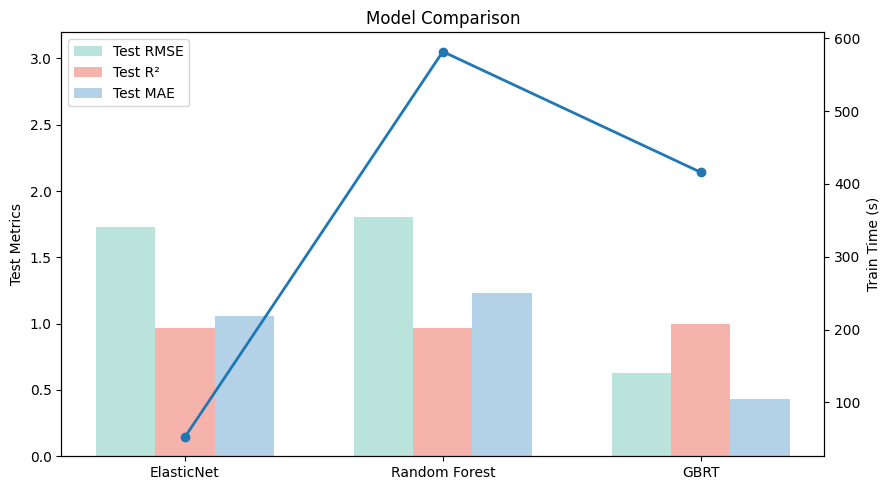

In [ ]:
import numpy as np

x = np.arange(len(df["model"]))
width = 0.23

fig, ax1 = plt.subplots(figsize=(9,5))

colors = ["#BAE3DC", "#F6B3AC", "#B3D1E7"]

ax1.bar(x - width, df["Test_RMSE"], width, label="Test RMSE", color=colors[0])
ax1.bar(x,         df["Test_R2"],   width, label="Test R²",   color=colors[1])
ax1.bar(x + width, df["Test_MAE"],  width, label="Test MAE",  color=colors[2])

top = max(df["Test_RMSE"] + df["Test_R2"] + df["Test_MAE"])  # 最大的指标值
ax1.set_ylim(0, top * 0.8)

ax1.set_xticks(x)
ax1.set_xticklabels(df["model"])
ax1.set_ylabel("Test Metrics")
ax1.legend(loc="upper left")


ax2 = ax1.twinx()
offset = max(df["Test_RMSE"]) * 0.3
line_y = np.array(df["Train_time"]) + offset

ax2.plot(x, line_y, marker="o", linewidth=2)
ax2.set_ylabel("Train Time (s)")

plt.title("Model Comparison")
plt.tight_layout()
plt.show()


Train vs Test RMSE

In [ ]:
import matplotlib.pyplot as plt


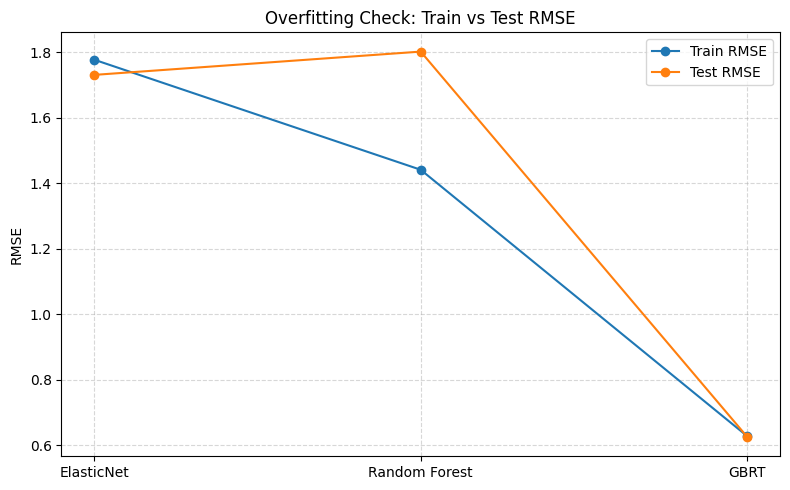

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(df["model"], df["Train_RMSE"], marker="o", label="Train RMSE")
plt.plot(df["model"], df["Test_RMSE"], marker="o", label="Test RMSE")

plt.ylabel("RMSE")
plt.title("Overfitting Check: Train vs Test RMSE")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
